In [1]:
import os, shutil
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from IPython.display import Image
import imutils
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

In [2]:
'''
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()
'''

'\nimport zipfile\nz = zipfile.ZipFile("archive.zip")\nz.extractall()\n'

In [3]:
'''
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_"+str(count)+".jpg"
    os.rename(source,destination)
    count+=1
    
print("All Files are renamed in the yes dir")
'''

'\nfolder = \'brain_tumor_dataset/yes/\'\ncount = 1\n\nfor filename in os.listdir(folder):\n    source = folder + filename\n    destination = folder + "Y_"+str(count)+".jpg"\n    os.rename(source,destination)\n    count+=1\n    \nprint("All Files are renamed in the yes dir")\n'

In [4]:
'''
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_"+str(count)+".jpg"
    os.rename(source,destination)
    count+=1
    
print("All Files are renamed in the no dir")
'''

'\nfolder = \'brain_tumor_dataset/no/\'\ncount = 1\n\nfor filename in os.listdir(folder):\n    source = folder + filename\n    destination = folder + "N_"+str(count)+".jpg"\n    os.rename(source,destination)\n    count+=1\n    \nprint("All Files are renamed in the no dir")\n'

# **EDA**

In [5]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


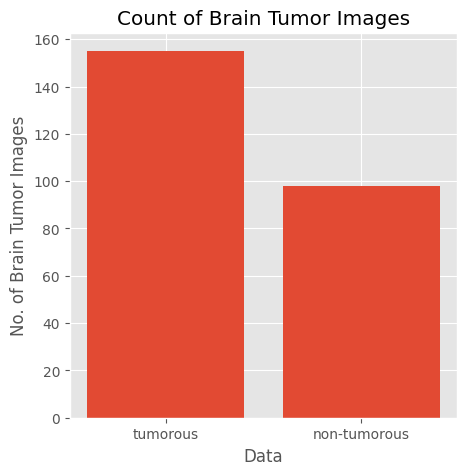

In [6]:
data = {'tumorous': number_files_yes, 'non-tumorous':number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,5))
plt.bar(typex,values)

plt.xlabel("Data")
plt.ylabel("No. of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# **Data Augumentation**
- 155(61% yes) and 98(39% no)
- imbalance data problem 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19  # Corrected import
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break